## Pesquisa

Essa pesquisa tem o objetivo de analisar os dados de simulação do Tennessee Eastman com o algoritmo de seleção SHAP, em conjunto com o Random Forest para classificar as falhas, caso sejam ou não a falha informada. Aprofundando no tema, a ideia é utilizar o algortimo SHAP para verificar quais váriaveis conseguem identificar uma falha, por exemplo, unindo todas as falhas e separando uma delas para ser a classe verdadeira, podemos identificar quais variaveis tiveram maior contribuição para aquela especifica falha.

### Separação dos dados

Os dados foram separados em treino, teste e validação. Os dados de treino e de testes foram montados com as primeiras 40 ocorrencias de cada, exceto a selecionada para ser a classe positiva. Já os dados de validação, são os dados não utilizados pelas demais separações.

### Tecnologia implementada

Nesse artigo, foi utilizado o algoritmo SHAP para a seleção das variaveis mais importantes para identificar a falha e o Random Forest para classificar e testar tais variaveis.
Para a classificação, foi utilizado para medir o poder do conjunto utilizando as métrica F1, acuracia, recall, espeficidade e precisão.
Para fins de comparação, foram utilizados alguns gráficos e heatmaps para melhor analise entre artigos selecionados.

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pylab as plt
from tennessee_eastman import get_faulty_by_id, get_faulties
from shap_contribution import get_shap_contribution, plot_variable
from pca_contribution import get_pca_contribution, t2s, t2t
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.feature_selection import RFE, f_classif, SelectFromModel, mutual_info_classif, SelectKBest
import warnings
import sys
from tabulate import tabulate

plt.style.use("seaborn")
warnings.filterwarnings("ignore")

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


In [2]:
all_features_for_selection = pd.DataFrame()
selected_fault = 1


def select_features(X, y, selector='RFE'):
    global all_features_for_selection
    model = RandomForestClassifier(random_state=1234)
    all_subsets = pd.DataFrame()

    for i in range(1, 21):


        if selector == 'RFE':
            featureSelector = RFE(model, n_features_to_select=i)
            featureSelector.fit(X, y)
        if selector == 'FromModel':
            featureSelector = SelectFromModel(estimator=model, max_features=i)
            featureSelector.fit(X, y)
        if selector == 'Classif':
            featureSelector = SelectKBest(f_classif, k=i)
            featureSelector.fit_transform(X, y)
        if selector == 'MultiClassif':
            featureSelector = SelectKBest(mutual_info_classif, k=i)
            featureSelector.fit_transform(X, y)

        indexes = np.nonzero(featureSelector.get_support())

        X_selected = X_train[:, indexes[0]]
        X_test_selected = X_test[:, indexes[0]]

        model = RandomForestClassifier(random_state=1234)
        model.fit(X_selected, y_train)

        predicted = model.predict(X_test_selected)
        result = f1_score(y_test, predicted)

        all_features_for_selection = all_features_for_selection.append(
            {'selector': selector, 'f1_score': result, 'indexes': indexes, 'numberFeatures': len(indexes[0]),
             'fault': selected_fault}, ignore_index=True)
        all_subsets = all_subsets.append(
            {'selector': selector, 'f1_score': result, 'indexes': indexes, 'numberFeatures': len(indexes[0]),
             'fault': selected_fault}, ignore_index=True)

    all_subsets.sort_values(by=['f1_score'], ascending=False, inplace=True)
    return all_subsets['f1_score'][0]

### Creating the heat map data with all variables and failures (The heat map is shown in the end of this file)

In [3]:
all_contributions = []

for i in range(1, 22):
    # Setting up the dataset with all falties with binary distribution
    X_train, y_train, X_test, y_test = get_faulties(i)

    print(y_train.shape, y_test.shape)

    model = RandomForestClassifier(random_state=1234)

    # Calculating the variables contributions
    contributions = get_shap_contribution(model, X_train, y_train, X_test)

    aux = contributions.to_numpy()

    all_contributions.append(aux / aux.sum(axis=0) * 100)

heatmap_data = all_contributions = np.array(all_contributions).reshape(21, 52)

(1440,) (1760,)
(1440,) (1760,)
(1440,) (1760,)
(1440,) (1760,)
(1440,) (1760,)
(1440,) (1760,)
(1440,) (1760,)
(1440,) (1760,)
(1440,) (1760,)
(1440,) (1760,)
(1440,) (1760,)
(1440,) (1760,)
(1440,) (1760,)
(1440,) (1760,)
(1440,) (1760,)
(1440,) (1760,)
(1440,) (1760,)
(1440,) (1760,)
(1440,) (1760,)
(1440,) (1760,)
(1440,) (1760,)


### Calculating with all metrics and selecting the best variables for each failures

In [ ]:
all_contributions = pd.DataFrame()
all_accuracies = pd.DataFrame()

for i in range(1, 22):
    global selected_fault
    # Setting up the dataset with all falties with binary distribution
    X_train, y_train, X_test, y_test = get_faulties(i)

    model = RandomForestClassifier(random_state=1234)

    # Calculating the variables contributions
    contributions = get_shap_contribution(model, X_train, y_train, X_test, True)

    accuracies = []
    f1s = []
    recalls = []
    precisions = []
    specificities = []

    all_scores = []
    scores = []
    used_variables = []
    all_variables = contribution_indexes = contributions.index.to_numpy()

    X_temporary = np.array([])
    X_test_temporary = np.array([])

    stop = False

    selectorsF1 = []

    for j in range(X_train.shape[1]):
        model = RandomForestClassifier(random_state=1234)

        # Setting up a new dataset with the selected variables
        X_temporary = np.concatenate((X_temporary, np.array([X_train[:, contribution_indexes[0]]]).T), axis=1) if X_temporary.shape[0] > 0 else np.array([X_train[:,contribution_indexes[0]]]).T
        X_test_temporary = np.concatenate((X_test_temporary, np.array([X_test[:, contribution_indexes[0]]]).T), axis=1) if X_test_temporary.shape[0] > 0 else np.array([X_test[:, contribution_indexes[0]]]).T

        model.fit(X_temporary, y_train)
        predicted = model.predict(X_test_temporary)

        # Calculating all metrics
        f1_aux = f1_score(y_test, predicted)
        accuracy_aux = accuracy_score(y_test, predicted)
        recall_aux = recall_score(y_test, predicted)
        precision_aux = precision_score(y_test, predicted)
        tn_aux, fp_aux, fn_aux, tp_aux = confusion_matrix(y_test, predicted).ravel()
        specificity_aux = tn_aux / (tn_aux + fp_aux)

        if (len(scores) == 0 or (len(scores) > 0 and scores[len(scores) - 1] < f1_aux)):
            used_variables.append(contribution_indexes[0])
            scores.append(f1_aux)
            f1 = f1_aux
            accuracy = accuracy_aux
            recall = recall_aux
            precision = precision_aux
            tn = tn_aux
            fp = fp_aux
            fn = fn_aux
            tp = tp_aux
            specificity = specificity_aux

            contribution_indexes = np.delete(contribution_indexes, 0)

        all_scores.append(f1_aux)

        print(used_variables)

        # Adding this accuracy to the dataframe
        all_accuracies = all_accuracies.append(
            {'index': i, 'f1': f1, 'accuracy': accuracy, 'recall': recall, 'precision': precision, 'specificity': specificity,
             'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp, 'scores': scores, 'all_scores': all_scores,
             'used_variables': used_variables, 'all_variables': all_variables,}, ignore_index=True)

# Adding this contribution to the dataframe
        all_contributions = all_contributions.append({'index': i, 'value': contributions.index}, ignore_index=True)

##### Simple metrics results

In [ ]:
print(tabulate(all_accuracies.drop(
    ['scores', 'all_scores', 'used_variables', 'all_variables', 'rfe', 'fromModel', 'class', 'multiclass'],
    axis=1).round(4), tablefmt='psql', headers="keys"))

##### Selected variables and scores

In [ ]:
temporary_df = all_accuracies.copy()

for i in range(len(temporary_df['scores'])):
    for j in range(len(temporary_df['scores'][i])):
temporary_df['scores'][i][j] = round(temporary_df['scores'][i][j], 4)

print(tabulate(temporary_df[['index', 'scores', 'used_variables']], tablefmt='psql', headers='keys',
               maxcolwidths=[1, 1, 50, 50]))

##### All variables and scores

In [ ]:
for i in range(len(temporary_df['all_scores'])):
    for j in range(len(temporary_df['all_scores'][i])):
temporary_df['all_scores'][i][j] = round(temporary_df['all_scores'][i][j], 4)

print(tabulate(all_accuracies[['index', 'all_scores', 'all_variables']], tablefmt='psql', headers='keys',
               maxcolwidths=[1, 1, 50, 50]))

##### Score results with selected variables

In [ ]:
for failure in range(21):
    plt.plot(all_accuracies["all_scores"][failure], zorder=1)
    plt.xticks(range(52), all_accuracies["all_variables"][failure], fontsize=8, rotation=90)

    plt.scatter(x=len(all_accuracies["used_variables"][failure]) - 1,
                y=next(reversed(all_accuracies["scores"][failure])), color='r', zorder=2)
    plt.title("Failure " + str(failure + 1))
    plt.show()

##### Heatmaps

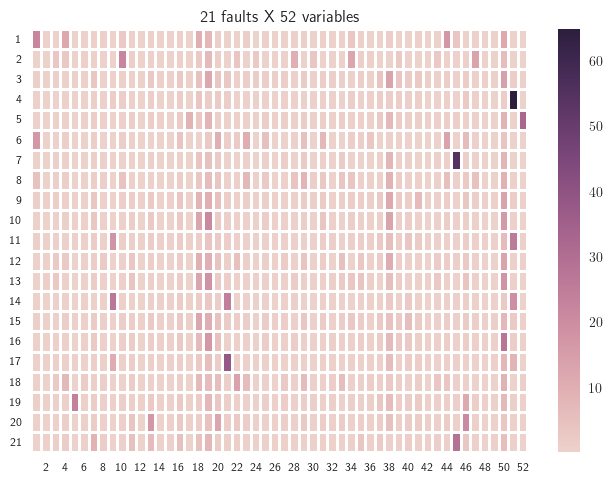

In [6]:
np.set_printoptions(threshold=sys.maxsize, suppress=True)
np.set_printoptions()

#plt.rcParams['pdf.fonttype'] = 42
#plt.rcParams['ps.fonttype'] = 42

plt.rcParams['text.usetex'] = True

fig = plt.figure()
heat_map = sns.heatmap(heatmap_data, linewidth=1, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title('21 faults X 52 variables')
plt.yticks(np.arange(1, 22, 1) - 0.5, np.arange(1, 22, 1), fontsize=8, rotation=0, va='center')
plt.xticks(np.arange(1, 53, 2) + 0.5, np.arange(1, 53, 2) + 1, fontsize=8)
plt.show()
fig.savefig("2152.eps", format='eps')
plt.close()

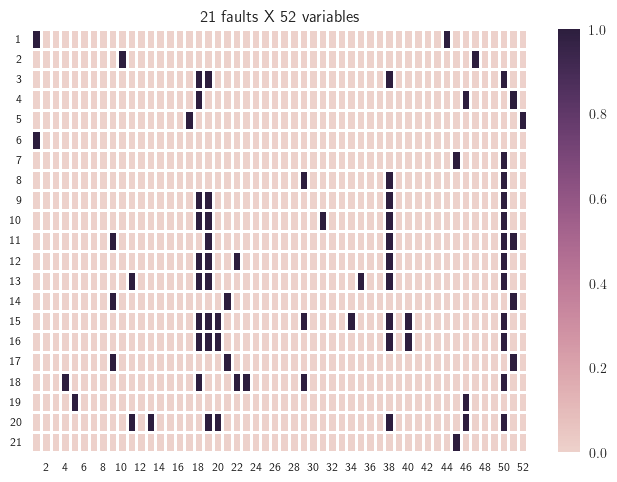

In [7]:
binary_heatmap_data = []
usedteste = [[1, 44],
 [ 10, 47],
 [ 50, 38, 19, 18],
 [ 51, 18, 46],
 [ 52, 17],
 [ 1]  ,
 [ 45, 50],
 [50, 38, 29],
 [ 50, 38, 19, 18] ,
 [19, 50, 38, 18, 31],
 [51, 9, 50, 38, 19],
 [50, 38, 19, 18, 22],
 [ 19, 50, 18, 38, 35, 11] ,
 [ 9, 21, 51 ],
 [18, 19, 50, 40, 38, 20, 29, 34],
 [ 50, 19, 38, 18, 20, 40],
 [21, 9, 51],
 [ 22, 50, 4, 18, 29, 23],
 [5, 46],
 [46, 13, 20, 38, 19, 11, 50],
 [45]]
for i in range(21):
    binary_heatmap_data.append([])

    for j in range(52):
        binary_heatmap_data[i].append(0)

    for x in usedteste[i]:
        binary_heatmap_data[i][x -1] = 1

fig2 = plt.figure()
heat_map = sns.heatmap(binary_heatmap_data, linewidth=1, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title('21 faults X 52 variables')
plt.yticks(np.arange(1, 22, 1) - 0.5, np.arange(1, 22, 1), fontsize=8, rotation=0, va='center')
plt.xticks(np.arange(1, 53, 2) + 0.5, np.arange(1, 52, 2) + 1, fontsize=8)
plt.show()
fig2.savefig("21525.eps", format='eps')
plt.close()

In [ ]:
scores_bar = []
all_scores_bar = []

for i in range(21):
    scores_aux = all_accuracies['scores'].to_numpy()[i]
    all_scores_aux = all_accuracies['all_scores'].to_numpy()[i]

    scores_bar.append(scores_aux[len(scores_aux) - 1])
    all_scores_bar.append(all_scores_aux[len(all_scores_aux) - 1])

plt.bar(np.arange(21) - 0.2, scores_bar, 0.4, label="SHAP")
plt.bar(np.arange(21) + 0.2, all_scores_bar, 0.4, label="All variables")

plt.xticks(range(21), range(1, 22))
plt.xlabel("Failures")
plt.ylabel("F1")
plt.title("Comparison between all variables and variables selected by SHAP")
plt.legend()
plt.show()

In [ ]:
rfe_score = all_accuracies['rfe']
class_score = all_accuracies['class']
shap_score = all_accuracies['f1']
multi_score = all_accuracies['multiclass']
model_score = all_accuracies['fromModel']

plt.bar(np.arange(21) - 0.2, rfe_score, 0.1, label="RFE")
plt.bar(np.arange(21) - 0.1, class_score, 0.1, label="Class")
plt.bar(np.arange(21), shap_score, 0.1, label="SHAP")
plt.bar(np.arange(21) + 0.1, multi_score, 0.1, label="Multi Class")
plt.bar(np.arange(21) + 0.2, model_score, 0.1, label="From Model")

plt.xticks(range(21), range(1, 22))
plt.xlabel("Feature selectors")
plt.ylabel("F1 score")
plt.title("Comparison between feature selectors")
plt.legend()

In [ ]:
all_features_for_selection.sort_values(by=['f1_score', 'numberFeatures'], ascending=[False, True], inplace=True)

In [ ]:
print(all_features_for_selection.loc[
          (all_features_for_selection['fault'] == 6) & (all_features_for_selection['selector'] == 'RFE')])

In [ ]:
print(all_features_for_selection.drop_duplicates(subset=['selector', 'fault']))

In [ ]:
show_best_scores = all_features_for_selection.drop_duplicates(subset=['selector', 'fault'])
show_best_scores.sort_values(by=['fault', 'selector'], ascending=True, inplace=True)

print(tabulate(show_best_scores, tablefmt='psql', headers="keys"))

In [ ]:
tShap = [0.9912, 0.9918, 0.624, 0.9994, 0.9893, 1, 1, 0.9281, 0.5807, 0.8519, 0.8896, 0.9329, 0.9333, 1, 0.5378, 0.8456,
         0.9764, 0.8859, 0.7701, 0.8694, 0.9981]
tRFE = [0.9912, 0.9924, 0.5924, 0.9994, 0.9893, 1, 1, 0.9515, 0.6029, 0.8463, 0.9145, 0.9583, 0.9263, 1, 0.5078, 0.885,
        0.9743, 0.9094, 0.9105, 0.8629, 0.9981]
tSFM = [0.9912, 0.9924, 0.625, 0.9994, 0.9893, 1, 1, 0.9411, 0.5745, 0.8388, 0.9183, 0.9453, 0.9255, 1, 0.5173, 0.8698,
        0.9743, 0.9047, 0.8961, 0.8629, 0.9981]
tAnova = [0.9912, 0.9918, 0.6178, 0.9994, 0.8025, 1, 1, 0.9333, 0.566, 0.8196, 0.6491, 0.9453, 0.9138, 0.5573, 0.5308,
          0.8921, 0.9384, 0.914, 0.877, 0.8189, 0.6441]
tMI = [0.9912, 0.9924, 0.5514, 0.9994, 0.8002, 1, 1, 0.9431, 0.5045, 0.8038, 0.8912, 0.9225, 0.9342, 1, 0.4379, 0.7856,
       0.9545, 0.909, 0.754, 0.7703, 0.9981]

from scipy.stats import wilcoxon

print("SHAP - RFE",wilcoxon(tShap, tRFE))
print("SHAP - SFM",  wilcoxon(tShap, tSFM))
print("SHAP - ANOVA", wilcoxon(tShap, tAnova))
print("SHAP - MI",  wilcoxon(tShap, tMI))

print("RFE - SFM",  wilcoxon(tRFE, tSFM))
print("RFE - ANOVA",  wilcoxon(tRFE, tAnova))
print("RFE - MI",  wilcoxon(tRFE, tMI))

print("SFM - ANOVA",  wilcoxon(tSFM, tAnova))
print("SFM - MI",  wilcoxon(tSFM, tMI))

print("ANOVA - MI",  wilcoxon(tAnova, tMI))

## Conclusão

Como demonstrado nessa implementação, o SHAP obteve um grande ganho comparado a utilização de todos os dados. Também foi demonstrado que a condição de parada para a escolha das variáveis pode ser removido, pois resultados melhores podem ser obtidos em troca de maior uso de dados.

Analizando os gráficos produzidos de cada variável escolhida pelo SHAP, nota-se que as variáveis mais importantes são as que tem maior variação nas amostras, aumentando a taxa de detecção dessas falhas. Além disso, em comparação com outros seletores de variáveis, o SHAP apresenta maior consistência na métrica F1 em todos as falhas. O RFE também teve ótimo desempenho, entretanto, na falha 21 não obteve um bom resultado.

Segundo o heatmap, é possível identificar as falhas de acordo com a oscilação de cada variável ao decorrer das amostras, já que para cada falha as primeiras 5 variáveis selecionadas são diferentes entre as demais. Também é possível remover certas variáveis do conjunto de dados, pois não são utilizados pelo SHAP e podem reduzir a acurácia do modelo.

